In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/split-events/event_11.csv
/kaggle/input/split-events/event_04.csv
/kaggle/input/split-events/event_02.csv
/kaggle/input/split-events/event_13.csv
/kaggle/input/split-events/event_12.csv
/kaggle/input/split-events/event_14.csv
/kaggle/input/split-events/event_10.csv
/kaggle/input/split-events/kaggle_feature_extraction.py
/kaggle/input/split-events/event_07.csv
/kaggle/input/split-events/kaggle_test_feature_extraction.py
/kaggle/input/split-events/earthquake_utils.py
/kaggle/input/split-events/event_09.csv
/kaggle/input/split-events/event_15.csv
/kaggle/input/split-events/event_03.csv
/kaggle/input/split-events/event_05.csv
/kaggle/input/split-events/event_16.csv
/kaggle/input/split-events/event_08.csv
/kaggle/input/split-events/event_06.csv
/kaggle/input/split-events/event_01.csv
/kaggle/input/split-events/event_17.csv
/kaggle/input/split-events/feature/event_07_features.csv
/kaggle/input/split-events/feature/event_02_features.csv
/kaggle/input/split-events/feature/event_0

In [2]:
"""
Kaggle Train용 Feature Extraction 스크립트
- 세그먼트 분할 (150,000) + 패딩 먼저
- 각 세그먼트별로 raw_* + std_* 피처 추출
- earthquake_utils.py 필요
"""

import os
import sys
import glob
import numpy as np
import pandas as pd

# sys.path 추가
if '/kaggle/input/split-events' not in sys.path:
    sys.path.insert(0, '/kaggle/input/split-events')

from earthquake_utils import (
    segment_data_from_back,
    extract_all_features,
)

# ==================== 설정 ====================
SEGMENT_SIZE = 150_000
LAST_WINDOW = 20_000
ROLLING_WINDOW = 1_000
SR = 4_000_000
HF_CUTOFF = 1_000_000
BAND_EDGES = (0, 100_000, 500_000, 1_000_000, 2_000_000)
OUTPUT_DIR = "/kaggle/working/features_train"

# ==================== 함수 ====================
def _infer_ttf_end_index(seg_id, total_len, segment_size):
    """세그먼트의 마지막 인덱스 계산"""
    remainder = total_len % segment_size
    if remainder == 0:
        return min((seg_id + 1) * segment_size - 1, total_len - 1)
    if seg_id == 0:
        return remainder - 1
    start = remainder + (seg_id - 1) * segment_size
    return min(start + segment_size - 1, total_len - 1)


def process_one_file(input_path, output_path):
    """한 개 train CSV 파일 처리"""
    df = pd.read_csv(input_path)

    if "acoustic_data" not in df.columns:
        raise ValueError(f"'acoustic_data' column not found in {input_path}")

    x_raw = df["acoustic_data"].values.astype(float)
    y = df.get("time_to_failure", None)

    print(f"  원본: {len(x_raw):,} samples | mean={x_raw.mean():.2f}, std={x_raw.std():.2f}")

    # ===== 1. 세그먼트 분할 + 패딩 (표준화 없이!) =====
    print(f"  [1] Segmenting raw data (no standardization yet)...")
    segments_raw, seg_info = segment_data_from_back(x_raw, SEGMENT_SIZE)
    num_segments = seg_info['num_segments']

    print(f"      segments={num_segments}, remainder={seg_info['remainder']}")
    if seg_info['padding_info']:
        p = seg_info['padding_info']
        print(f"      padded seg {p['segment_id']} | size={p['padding_size']} | val={p['padding_value']:.2f}")

    # ===== 2. 각 세그먼트별 피처 추출 =====
    print(f"  [2] Extracting raw_* + std_* features per segment...")
    event_id = os.path.splitext(os.path.basename(input_path))[0]
    rows = []

    for seg_id, seg_raw in enumerate(segments_raw):
        # 원본 세그먼트로 raw_* + std_* 피처 계산
        feats = extract_all_features(
            data_raw=seg_raw,
            sr=SR,
            cutoff_hz=HF_CUTOFF,
            band_edges=BAND_EDGES,
            last_N=LAST_WINDOW,
            roll_w=ROLLING_WINDOW,
        )

        row = {"event_id": event_id, "segment_id": seg_id, **feats}

        # TTF 레이블 추가
        if y is not None:
            end_idx = _infer_ttf_end_index(seg_id, len(x_raw), SEGMENT_SIZE)
            row["ttf_end"] = float(y[end_idx])

        rows.append(row)

        # 디버깅 로그
        if seg_id < 3 or seg_id % 100 == 0:
            print(f"      seg {seg_id:03d} | raw_mean={feats.get('raw_mean', 0):+.2f}, raw_std={feats.get('raw_std', 0):.2f}")

    # ===== 3. 저장 =====
    out_df = pd.DataFrame(rows)
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    out_df.to_csv(output_path, index=False)
    print(f"  ✅ 저장: {output_path} ({len(out_df)} rows)")
    return out_df


def main():
    """메인 실행 함수"""
    print("=" * 80)
    print("TRAIN FEATURE EXTRACTION (SEGMENTATION FIRST)")
    print("=" * 80)

    # 파일 찾기
    files = sorted(glob.glob("/kaggle/input/split-events/event_*.csv"))
    print(f"찾은 파일: {len(files)}개")

    if len(files) == 0:
        print("❌ 파일을 찾지 못했습니다!")
        return

    print(f"Segment size: {SEGMENT_SIZE:,}")
    print(f"Output dir: {OUTPUT_DIR}")
    print("=" * 80)

    # 모든 파일 처리
    all_dfs = []
    for i, file_path in enumerate(files, 1):
        print(f"\n[{i}/{len(files)}] {os.path.basename(file_path)}")

        out_name = os.path.splitext(os.path.basename(file_path))[0] + "_features.csv"
        out_path = os.path.join(OUTPUT_DIR, out_name)

        df = process_one_file(file_path, out_path)
        all_dfs.append(df)

    # 전체 병합
    df_all = pd.concat(all_dfs, ignore_index=True)
    all_path = "/kaggle/working/all_train_features.csv"
    df_all.to_csv(all_path, index=False)

    print("\n" + "=" * 80)
    print("완료!")
    print("=" * 80)
    print(f"개별 파일: {OUTPUT_DIR}/")
    print(f"통합 파일: {all_path}")
    print(f"전체 행 수: {len(df_all):,}")
    print(f"컬럼 수: {len(df_all.columns)}")
    print(f"컬럼: {list(df_all.columns[:10])}... (총 {len(df_all.columns)}개)")
    print("=" * 80)

    # 샘플 출력
    print("\n샘플 데이터:")
    print(df_all.head())


if __name__ == "__main__":
    main()


TRAIN FEATURE EXTRACTION (SEGMENTATION FIRST)
찾은 파일: 17개
Segment size: 150,000
Output dir: /kaggle/working/features_train

[1/17] event_01.csv
  원본: 5,656,574 samples | mean=4.56, std=23.43
  [1] Segmenting raw data (no standardization yet)...
      segments=38, remainder=106574
      padded seg 0 | size=43426 | val=5.00
  [2] Extracting raw_* + std_* features per segment...
      seg 000 | raw_mean=+5.00, raw_std=4.69
      seg 001 | raw_mean=+4.67, raw_std=6.14
      seg 002 | raw_mean=+4.81, raw_std=5.83
  ✅ 저장: /kaggle/working/features_train/event_01_features.csv (38 rows)

[2/17] event_02.csv
  원본: 44,429,304 samples | mean=4.51, std=10.90
  [1] Segmenting raw data (no standardization yet)...
      segments=297, remainder=29304
      padded seg 0 | size=120696 | val=4.48
  [2] Extracting raw_* + std_* features per segment...
      seg 000 | raw_mean=+4.48, raw_std=1.18
      seg 001 | raw_mean=+4.24, raw_std=5.10
      seg 002 | raw_mean=+4.31, raw_std=4.27
      seg 100 | raw_mea

In [3]:
"""
Kaggle Test용 Feature Extraction 스크립트
- test 폴더의 2624개 CSV 파일 처리
- 각 파일은 이미 150,000행으로 세그먼트되어 있음
- 세그먼트 분할 불필요, raw_* + std_* 피처 추출
"""

import os
import sys
import glob
import numpy as np
import pandas as pd
from tqdm import tqdm

# sys.path 추가
if '/kaggle/input/split-events' not in sys.path:
    sys.path.insert(0, '/kaggle/input/split-events')

from earthquake_utils import extract_all_features

# ==================== 설정 ====================
LAST_WINDOW = 20_000
ROLLING_WINDOW = 1_000
SR = 4_000_000
HF_CUTOFF = 1_000_000
BAND_EDGES = (0, 100_000, 500_000, 1_000_000, 2_000_000)
OUTPUT_DIR = "/kaggle/working"

# ==================== 함수 ====================
def process_one_test_file(input_path):
    """
    Test 파일 1개 처리 (150,000행)

    Returns:
    --------
    dict: 피처 딕셔너리 (seg_id 포함)
    """
    # 1. 파일 읽기
    df = pd.read_csv(input_path)

    # acoustic_data 컬럼 확인
    if "acoustic_data" not in df.columns:
        raise ValueError(f"'acoustic_data' column not found in {input_path}")

    x_raw = df["acoustic_data"].values.astype(float)

    # 2. raw_* + std_* 피처 추출
    feats = extract_all_features(
        data_raw=x_raw,
        sr=SR,
        cutoff_hz=HF_CUTOFF,
        band_edges=BAND_EDGES,
        last_N=LAST_WINDOW,
        roll_w=ROLLING_WINDOW,
    )

    # 3. seg_id 추출 (파일명에서)
    # 예: seg_00001.csv -> seg_id = seg_00001
    filename = os.path.basename(input_path)
    seg_id = os.path.splitext(filename)[0]

    return {"seg_id": seg_id, **feats}


def main():
    """메인 실행 함수"""
    print("=" * 80)
    print("TEST FEATURE EXTRACTION (RAW + STD)")
    print("=" * 80)

    # 파일 찾기
    test_pattern = "/kaggle/input/split-events/test/test/*.csv"
    files = sorted(glob.glob(test_pattern))

    print(f"Test 파일 패턴: {test_pattern}")
    print(f"찾은 파일: {len(files):,}개")

    if len(files) == 0:
        print("❌ 파일을 찾지 못했습니다!")
        print("경로를 확인하세요:")
        # 가능한 경로 확인
        possible_paths = [
            "/kaggle/input/test/*.csv",
            "/kaggle/input/*/test/*.csv",
            "/kaggle/input/lanl-earthquake-prediction/test/*.csv",
        ]
        for path in possible_paths:
            found = glob.glob(path)
            if found:
                print(f"  ✅ {path}: {len(found)}개 파일 발견")
            else:
                print(f"  ❌ {path}: 없음")
        return

    print(f"예상 출력 행 수: {len(files):,}")
    print("=" * 80)

    # 모든 파일 처리
    rows = []

    print("\n파일 처리 중...")
    for file_path in tqdm(files, desc="Processing"):
        try:
            row = process_one_test_file(file_path)
            rows.append(row)
        except Exception as e:
            print(f"\n⚠️ 오류 ({os.path.basename(file_path)}): {e}")
            continue

    # DataFrame 생성
    df_test = pd.DataFrame(rows)

    # 저장
    output_path = os.path.join(OUTPUT_DIR, "test_features.csv")
    df_test.to_csv(output_path, index=False)

    print("\n" + "=" * 80)
    print("완료!")
    print("=" * 80)
    print(f"출력 파일: {output_path}")
    print(f"전체 행 수: {len(df_test):,}")
    print(f"컬럼 수: {len(df_test.columns)}")
    print(f"컬럼: {list(df_test.columns[:10])}... (총 {len(df_test.columns)}개)")
    print("=" * 80)

    # 샘플 출력
    print("\n샘플 데이터 (처음 5행):")
    print(df_test.head())

    # raw vs std 피처 확인
    raw_cols = [c for c in df_test.columns if c.startswith('raw_')]
    std_cols = [c for c in df_test.columns if c.startswith('std_')]
    print(f"\nraw_* 피처: {len(raw_cols)}개")
    print(f"std_* 피처: {len(std_cols)}개")
    print(f"기타: {len(df_test.columns) - len(raw_cols) - len(std_cols)}개 (seg_id 등)")

    return df_test


if __name__ == "__main__":
    main()


TEST FEATURE EXTRACTION (RAW + STD)
Test 파일 패턴: /kaggle/input/split-events/test/test/*.csv
찾은 파일: 2,624개
예상 출력 행 수: 2,624

파일 처리 중...


Processing: 100%|██████████| 2624/2624 [02:29<00:00, 17.58it/s]



완료!
출력 파일: /kaggle/working/test_features.csv
전체 행 수: 2,624
컬럼 수: 25
컬럼: ['seg_id', 'raw_mean', 'raw_std', 'raw_log_std', 'raw_min', 'raw_max', 'raw_range', 'raw_rms', 'raw_mad', 'raw_peak_to_peak']... (총 25개)

샘플 데이터 (처음 5행):
       seg_id  raw_mean   raw_std  raw_log_std  raw_min  raw_max  raw_range  \
0  seg_00030f  4.491780  4.893673     1.587943    -75.0    115.0      190.0   
1  seg_0012b5  4.171153  5.922820     1.778813   -140.0    152.0      292.0   
2  seg_00184e  4.610260  6.946967     1.938305   -193.0    248.0      441.0   
3  seg_003339  4.531473  4.114133     1.414428    -93.0     85.0      178.0   
4  seg_0042cc  4.128340  5.797144     1.757365   -147.0    177.0      324.0   

    raw_rms  raw_mad  raw_peak_to_peak  ...  std_zero_crossing_rate  \
0  6.642599      2.0             190.0  ...                0.301515   
1  7.244192      2.0             292.0  ...                0.304889   
2  8.337556      2.0             441.0  ...                0.315082   
3  6.120485   

LANL EARTHQUAKE PREDICTION - ENSEMBLE MODEL

[1/6] Loading data...
  Train: 4,201 rows x 27 columns
  Test: 2,624 rows x 25 columns

[2/6] Preprocessing...
  Features: 24
  Sample features: ['raw_mean', 'raw_std', 'raw_log_std', 'raw_min', 'raw_max']

[3/6] Training models with K-Fold CV...
  Device: cpu

  Fold 1/5
    Train: 3,360, Valid: 841
    Training LightGBM...
      LightGBM MAE: 2.0351
    Training Neural Network...
      Neural Network MAE: 2.0140
      Ensemble MAE: 1.9984 ⭐

  Fold 2/5
    Train: 3,361, Valid: 840
    Training LightGBM...
      LightGBM MAE: 2.2074
    Training Neural Network...
      Neural Network MAE: 2.1634
      Ensemble MAE: 2.1646 ⭐

  Fold 3/5
    Train: 3,361, Valid: 840
    Training LightGBM...
      LightGBM MAE: 2.1479
    Training Neural Network...
      Neural Network MAE: 2.0582
      Ensemble MAE: 2.0875 ⭐

  Fold 4/5
    Train: 3,361, Valid: 840
    Training LightGBM...
      LightGBM MAE: 2.0669
    Training Neural Network...
      Neural

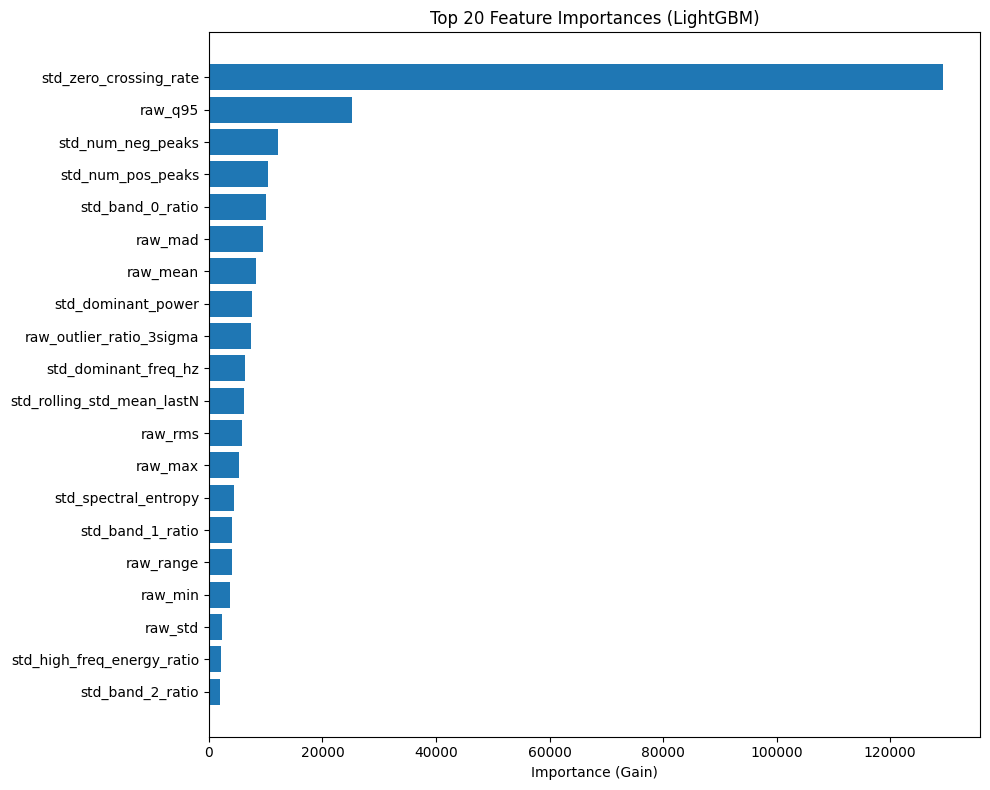

In [4]:
"""
LANL Earthquake Prediction - Ensemble Model
LightGBM + Neural Network Ensemble

Train: all_train_features.csv
Test: test_features.csv
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import warnings
warnings.filterwarnings('ignore')

# ==================== 설정 ====================
TRAIN_PATH = "/kaggle/working/all_train_features.csv"
TEST_PATH = "/kaggle/working/test_features.csv"
OUTPUT_PATH = "/kaggle/working/submission.csv"

N_FOLDS = 5
RANDOM_STATE = 42
LGBM_WEIGHT = 0.6  # LightGBM 가중치
NN_WEIGHT = 0.4    # Neural Network 가중치

# LightGBM 파라미터
LGBM_PARAMS = {
    'objective': 'regression',
    'metric': 'mae',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1,
    'random_state': RANDOM_STATE,
    'n_jobs': -1,
}

# Neural Network 파라미터
NN_PARAMS = {
    'hidden_dims': [256, 128, 64],
    'dropout': 0.3,
    'learning_rate': 0.001,
    'batch_size': 256,
    'epochs': 50,
}

# ==================== 데이터 로드 ====================
print("=" * 80)
print("LANL EARTHQUAKE PREDICTION - ENSEMBLE MODEL")
print("=" * 80)

print("\n[1/6] Loading data...")
train_df = pd.read_csv(TRAIN_PATH)
test_df = pd.read_csv(TEST_PATH)

print(f"  Train: {len(train_df):,} rows x {len(train_df.columns)} columns")
print(f"  Test: {len(test_df):,} rows x {len(test_df.columns)} columns")

# ==================== 전처리 ====================
print("\n[2/6] Preprocessing...")

# ID 컬럼 분리
train_ids = train_df[['event_id', 'segment_id']].copy()
test_ids = test_df[['seg_id']].copy()

# 피처 선택 (raw_*, std_* 만)
feature_cols = [col for col in train_df.columns
                if col.startswith('raw_') or col.startswith('std_')]

X_train = train_df[feature_cols].values
y_train = train_df['ttf_end'].values
X_test = test_df[feature_cols].values

print(f"  Features: {len(feature_cols)}")
print(f"  Sample features: {feature_cols[:5]}")

# NaN/Inf 처리
X_train = np.nan_to_num(X_train, nan=0.0, posinf=0.0, neginf=0.0)
X_test = np.nan_to_num(X_test, nan=0.0, posinf=0.0, neginf=0.0)

# ==================== Neural Network 정의 ====================
class EarthquakeDataset(Dataset):
    def __init__(self, X, y=None):
        self.X = torch.FloatTensor(X)
        self.y = torch.FloatTensor(y) if y is not None else None

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        if self.y is not None:
            return self.X[idx], self.y[idx]
        return self.X[idx]


class EarthquakeNN(nn.Module):
    def __init__(self, input_dim, hidden_dims=[256, 128, 64], dropout=0.3):
        super(EarthquakeNN, self).__init__()

        layers = []
        prev_dim = input_dim

        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, hidden_dim))
            layers.append(nn.BatchNorm1d(hidden_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
            prev_dim = hidden_dim

        layers.append(nn.Linear(prev_dim, 1))

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x).squeeze()


def train_nn_fold(X_tr, y_tr, X_val, y_val, input_dim):
    """Neural Network 학습"""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # 데이터셋
    train_dataset = EarthquakeDataset(X_tr, y_tr)
    val_dataset = EarthquakeDataset(X_val, y_val)

    train_loader = DataLoader(train_dataset, batch_size=NN_PARAMS['batch_size'],
                             shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=NN_PARAMS['batch_size'],
                           shuffle=False, num_workers=0)

    # 모델
    model = EarthquakeNN(input_dim, NN_PARAMS['hidden_dims'], NN_PARAMS['dropout']).to(device)
    criterion = nn.L1Loss()  # MAE
    optimizer = optim.Adam(model.parameters(), lr=NN_PARAMS['learning_rate'])
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5,
                                                     patience=5, verbose=False)

    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(NN_PARAMS['epochs']):
        # Train
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item()

        train_loss /= len(train_loader)
        val_loss /= len(val_loader)

        scheduler.step(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= 10:  # Early stopping
            break

    return model, best_val_loss


def predict_nn(model, X, device):
    """Neural Network 예측"""
    model.eval()
    dataset = EarthquakeDataset(X)
    loader = DataLoader(dataset, batch_size=NN_PARAMS['batch_size'],
                       shuffle=False, num_workers=0)

    predictions = []
    with torch.no_grad():
        for X_batch in loader:
            if isinstance(X_batch, list):
                X_batch = X_batch[0]
            X_batch = X_batch.to(device)
            outputs = model(X_batch)
            predictions.append(outputs.cpu().numpy())

    return np.concatenate(predictions)


# ==================== 학습 ====================
print("\n[3/6] Training models with K-Fold CV...")

kfold = KFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE)

lgbm_oof = np.zeros(len(X_train))
nn_oof = np.zeros(len(X_train))
lgbm_test_preds = []
nn_test_preds = []

lgbm_models = []
nn_models = []
fold_scores = []

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"  Device: {device}")

for fold, (train_idx, val_idx) in enumerate(kfold.split(X_train), 1):
    print(f"\n  Fold {fold}/{N_FOLDS}")
    print(f"    Train: {len(train_idx):,}, Valid: {len(val_idx):,}")

    X_tr, X_val = X_train[train_idx], X_train[val_idx]
    y_tr, y_val = y_train[train_idx], y_train[val_idx]

    # --- LightGBM ---
    print(f"    Training LightGBM...")
    train_data = lgb.Dataset(X_tr, label=y_tr)
    val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)

    lgbm_model = lgb.train(
        LGBM_PARAMS,
        train_data,
        num_boost_round=1000,
        valid_sets=[train_data, val_data],
        valid_names=['train', 'valid'],
        callbacks=[
            lgb.early_stopping(stopping_rounds=50, verbose=False),
            lgb.log_evaluation(period=0)
        ]
    )

    lgbm_val_pred = lgbm_model.predict(X_val, num_iteration=lgbm_model.best_iteration)
    lgbm_oof[val_idx] = lgbm_val_pred
    lgbm_test_pred = lgbm_model.predict(X_test, num_iteration=lgbm_model.best_iteration)
    lgbm_test_preds.append(lgbm_test_pred)
    lgbm_models.append(lgbm_model)

    lgbm_mae = mean_absolute_error(y_val, lgbm_val_pred)
    print(f"      LightGBM MAE: {lgbm_mae:.4f}")

    # --- Neural Network ---
    print(f"    Training Neural Network...")

    # NN용 표준화 (fold별로 독립적으로)
    scaler = StandardScaler()
    X_tr_scaled = scaler.fit_transform(X_tr)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)

    nn_model, nn_val_loss = train_nn_fold(X_tr_scaled, y_tr, X_val_scaled, y_val, X_tr.shape[1])

    nn_val_pred = predict_nn(nn_model, X_val_scaled, device)
    nn_oof[val_idx] = nn_val_pred
    nn_test_pred = predict_nn(nn_model, X_test_scaled, device)
    nn_test_preds.append(nn_test_pred)
    nn_models.append((nn_model, scaler))

    nn_mae = mean_absolute_error(y_val, nn_val_pred)
    print(f"      Neural Network MAE: {nn_mae:.4f}")

    # --- Ensemble ---
    ensemble_pred = LGBM_WEIGHT * lgbm_val_pred + NN_WEIGHT * nn_val_pred
    ensemble_mae = mean_absolute_error(y_val, ensemble_pred)

    print(f"      Ensemble MAE: {ensemble_mae:.4f} ⭐")
    fold_scores.append(ensemble_mae)

# ==================== OOF 평가 ====================
print("\n[4/6] Out-of-Fold Evaluation...")

lgbm_oof_mae = mean_absolute_error(y_train, lgbm_oof)
nn_oof_mae = mean_absolute_error(y_train, nn_oof)
ensemble_oof = LGBM_WEIGHT * lgbm_oof + NN_WEIGHT * nn_oof
ensemble_oof_mae = mean_absolute_error(y_train, ensemble_oof)

print(f"  LightGBM OOF MAE: {lgbm_oof_mae:.4f}")
print(f"  Neural Network OOF MAE: {nn_oof_mae:.4f}")
print(f"  Ensemble OOF MAE: {ensemble_oof_mae:.4f} ⭐")
print(f"  Average Fold MAE: {np.mean(fold_scores):.4f} ± {np.std(fold_scores):.4f}")

# ==================== Test 예측 ====================
print("\n[5/6] Predicting on test set...")

lgbm_test_final = np.mean(lgbm_test_preds, axis=0)
nn_test_final = np.mean(nn_test_preds, axis=0)
ensemble_test_final = LGBM_WEIGHT * lgbm_test_final + NN_WEIGHT * nn_test_final

print(f"  LightGBM predictions: mean={lgbm_test_final.mean():.4f}, std={lgbm_test_final.std():.4f}")
print(f"  Neural Network predictions: mean={nn_test_final.mean():.4f}, std={nn_test_final.std():.4f}")
print(f"  Ensemble predictions: mean={ensemble_test_final.mean():.4f}, std={ensemble_test_final.std():.4f}")

# ==================== 제출 파일 생성 ====================
print("\n[6/6] Creating submission file...")

submission = pd.DataFrame({
    'seg_id': test_ids['seg_id'],
    'time_to_failure': ensemble_test_final
})

submission.to_csv(OUTPUT_PATH, index=False)
print(f"  Saved: {OUTPUT_PATH}")

# ==================== Feature Importance (LightGBM) ====================
print("\n[Bonus] Top 20 Feature Importances (LightGBM average)...")

feature_importance = np.zeros(len(feature_cols))
for model in lgbm_models:
    feature_importance += model.feature_importance(importance_type='gain')
feature_importance /= len(lgbm_models)

importance_df = pd.DataFrame({
    'feature': feature_cols,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print(importance_df.head(20).to_string(index=False))

# 시각화 저장
plt.figure(figsize=(10, 8))
top20 = importance_df.head(20)
plt.barh(range(len(top20)), top20['importance'])
plt.yticks(range(len(top20)), top20['feature'])
plt.xlabel('Importance (Gain)')
plt.title('Top 20 Feature Importances (LightGBM)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('/kaggle/working/feature_importance.png', dpi=150, bbox_inches='tight')
print(f"  Feature importance plot saved: feature_importance.png")

print("\n" + "=" * 80)
print("TRAINING COMPLETE!")
print("=" * 80)
print(f"Final Ensemble OOF MAE: {ensemble_oof_mae:.4f}")
print(f"Submission file: {OUTPUT_PATH}")
print("=" * 80)
